### CSE 5320 Neural Networks Project 3 with Paper
#### Report (with Code)
Josias Moukpe\
12/10/2022

#### Introduction
Text Generation is a branch of Natural Language Processing (NLP) that predicts the
next most likely word given all the previous words. State of the art in Text Generation
has recently been the domain of Language Models based on Transformers pretrained
on large corpora of text data from various sources on the internet. These pretrained
generative transformers are often fine-tuned on a downstream dataset for a
downstream task of interest. This project aims to develop a generative language model
based on a pretrained language transformer fine-tuned on our two chosen datasets:
Merve-Poetry [1] and Rap Lyrics US [2]. We want to obtain a fine-tuned model that can
generate original English poetry given an initial prompt and another that can generate
original rap lyrics inspired by the styles of contemporary rappers. Both datasets contain
English text from various authors and will be processed to extract the bags of words.
Those words will then be converted to a designated embedding before being ingested
by the generative model during fine-tuning. The pretrained model will be obtained from
the Hugging Face library of generative models for English text.
Merve Poetry contains renaissance and modern poetries from subjects such as Love,
Nature, Mythology, and Folklore. The dataset is organized into 5 table columns: the
poem's content, author, age, and subject type. Rap Lyrics US contains text documents
organized by artists. Each text document includes lyrics from the corresponding artist.
The final models will take an initial sequence of words (prompt) and generate a
sequence from an original poem and rap song.

#### Problem


#### Methodology


#### Benchmarking


#### Conclusion



References\
[1] https://huggingface.co/datasets/merve/poetry/viewer/merve--poetry/train\
[2] https://github.com/fpaupier/RapLyrics-Scraper/tree/master/lyrics_US\
[3]https://huggingface.co/models?language=en&library=tf&pipeline_tag=text-generation&sort=downloads\
[3] https://www.projectpro.io/recipes/what-is-causal-language-modeling-transformers\
[4] https://towardsdatascience.com/understanding-masked-language-models-mlm-and-causal-language-models-clm-in-nlp-194c15f56a5\
[5] https://github.com/christianversloot/machine-learning-articles/blob/main/easy-causal-language-modeling-with-machine-learning-and-huggingface-transformers.md

#### Remote Training Environment Setup

In [ ]:
%pip install tensorflow_addons%
%pip install transformers
%pip install datasets

In [1]:
# imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow_addons.optimizers import AdamW
from tqdm import tqdm
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.strings import regex_replace
from transformers import AutoTokenizer
from transformers import TFOPTForCausalLM
from transformers import OPTConfig
from transformers import tf_top_k_top_p_filtering
from transformers import DefaultDataCollator
from datasets import load_dataset

c:\Users\the_3\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# gpu
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Handling the data

In [3]:

lyrics_path = './data/lyrics.json'

In [4]:
# use a generator to read the json file
def parse(dataset_path):
    '''
        This function reads the json file and returns a generator
    '''
    dataf = open(dataset_path, 'r', encoding='utf-8')
    for line in dataf:
        # get the text and stars
        yield json.loads(line)['author'], json.loads(line)['content']


In [5]:
def plot_stats(dataset, plotting=True):
    '''
        This function plots the number of authors and content,
        the average number of words per content and the average
        number of characters per content

        Parameters:
            dataset_path (str): path to the dataset or generator
            plotting (bool): if True, it plots the number of contents
    '''


    # check if the dataset is a generator or a path
    if isinstance(dataset, str):
        data_gen = parse(dataset)
    else:
        data_gen = dataset

    authors = []
    contents = []
    for author, content in data_gen:
        authors.append(author)
        contents.append(content)
        
    # number of authors
    print('Number of authors: ', len(set(authors)))

    # number of contents
    print('Number of contents: ', len(contents))

    # average number of words per content
    print('Average number of words per content: ', np.mean([len(content.split()) for content in contents]))

    # longest number of words per content
    print('Longest number of words per content: ', np.max([len(content.split()) for content in contents]))

    # shortest number of words per content
    print('Shortest number of words per content: ', np.min([len(content.split()) for content in contents]))

    # for every content, count the number of characters
    print('Average number of characters per content: ', np.mean([len(content) for content in contents]))

    if plotting:
        # for every author, count the number of contents
        authors_count = {}
        for author in authors:
            if author in authors_count:
                authors_count[author] += 1
            else:
                authors_count[author] = 1

        # plot the number of contents per author
        plt.figure(figsize=(20, 10))
        plt.bar(authors_count.keys(), authors_count.values())
        plt.xticks(rotation=90)
        plt.title('Number of contents per author')
        plt.xlabel('Author')
        plt.ylabel('Number of contents')
        plt.show()

        # for every content, count the number of words
        contents_count = {}
        for content in contents:
            if len(content.split()) in contents_count:
                contents_count[len(content.split())] += 1
            else:
                contents_count[len(content.split())] = 1

        # plot the number of contents per number of words
        plt.figure(figsize=(20, 10))
        plt.bar(contents_count.keys(), contents_count.values())
        plt.xticks(rotation=90)
        plt.title('Number of contents per number of words')
        plt.xlabel('Number of words')
        plt.ylabel('Number of contents')
        plt.show()
        

    

Number of authors:  36
Number of contents:  10255
Average number of words per content:  120.92891272549976
Longest number of words per content:  2943
Shortest number of words per content:  1
Average number of characters per content:  617.3304729400293


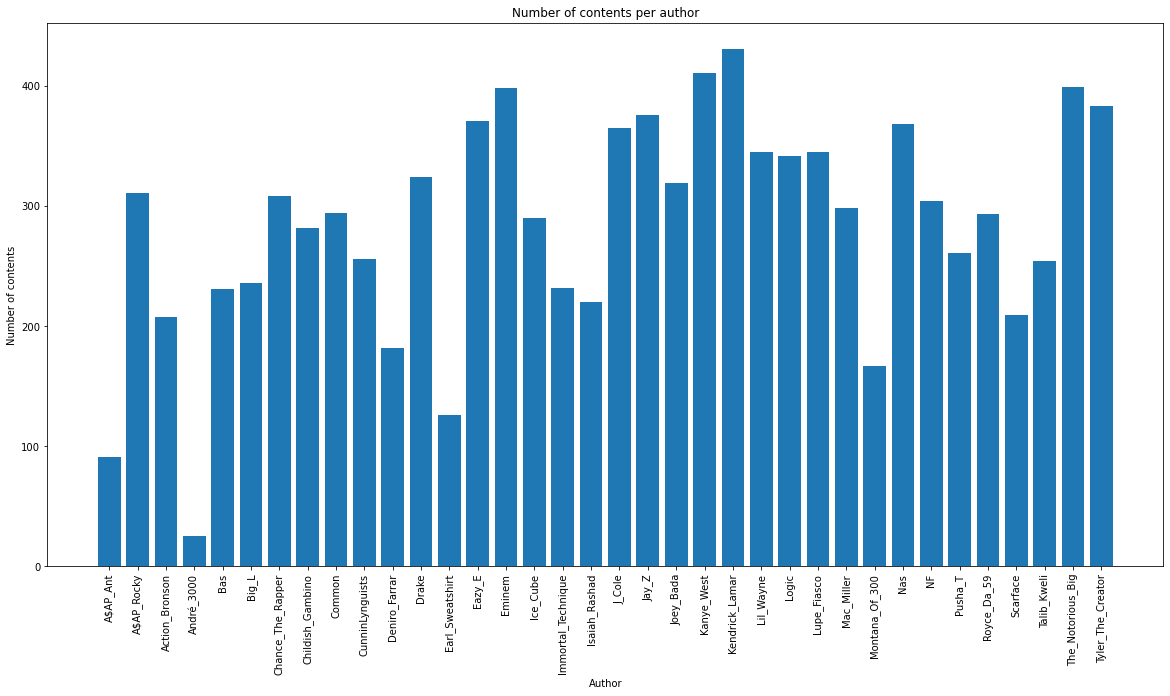

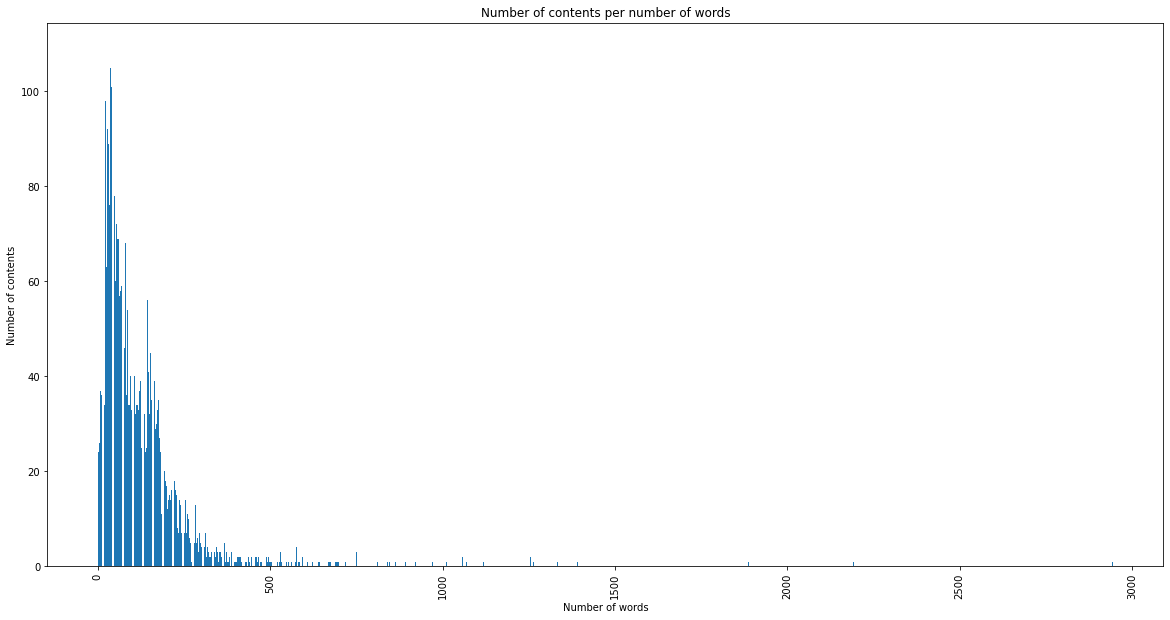

In [6]:
plot_stats(lyrics_path)

In [7]:
# read path file write to a json file
def split_dataset(name, og_path, split=[.8, .1, .1]):
    '''
        read a json file and split it into train, test, and validation
        files according to the split parameter
    '''
    # get directory path
    dir_path = '/'.join(og_path.split('/')[:-1])
    # get the generator
    data = parse(og_path)
    # loop through the generator
    for author, content in data:
        # generate a random number between 0 and 1
        r = np.random.rand()
        # if the random number is less than the first split
        if r < split[0]:
            # write to the train file
            with open(dir_path + f'/{name}_train.json', 'a') as f:
                f.write(json.dumps({'author': author, 'content': content}))
                f.write('\n')
        # if the random number is less than the first split plus the second split
        elif r < split[0] + split[1]:
            # write to the validation file
            with open(dir_path + f'/{name}_val.json', 'a') as f:
                f.write(json.dumps({'author': author, 'content': content}))
                f.write('\n')
        # if the random number is less than the first split plus the second split plus the third split
        else:
             # write to the test file
            with open(dir_path + f'/{name}_test.json', 'a') as f:
                f.write(json.dumps({'author': author, 'content': content}))
                f.write('\n')

In [8]:
# split the lyrics dataset
split_dataset('lyrics', lyrics_path)

In [9]:
# read the train, test, and validation files
def read_dataset(name, path):
    '''
        read the train, test, and validation files
        Input:
            name: the name of the dataset
            path: the path to the dataset
        Output:
            train_ds: the train dataset generator
            val_ds: the validation dataset generator
            test_ds: the test dataset generator
    '''
    # read the train file
    train_path = f"./data/{name}_train.json"
    validation_path = f"./data/{name}_val.json"
    test_path = f"./data/{name}_test.json"

    train_ds = parse(train_path)
    val_ds = parse(validation_path)
    test_ds = parse(test_path)

    return train_ds, val_ds, test_ds
    

In [10]:

# read the lyrics dataset
lyrics_train_ds, lyrics_val_ds, lyrics_test_ds = read_dataset('lyrics', lyrics_path)


In [11]:

# the stats for the lyrics dataset
print('Trainig set')
plot_stats(lyrics_train_ds, plotting=False)
print('Validation set')
plot_stats(lyrics_val_ds, plotting=False)
print('Test set')
plot_stats(lyrics_test_ds, plotting=False)


Trainig set
Number of authors:  36
Number of contents:  8242
Average number of words per content:  120.12011647658335
Longest number of words per content:  2816
Shortest number of words per content:  1
Average number of characters per content:  613.2181509342392
Validation set
Number of authors:  36
Number of contents:  1017
Average number of words per content:  126.02458210422812
Longest number of words per content:  2943
Shortest number of words per content:  2
Average number of characters per content:  643.1937069813176
Test set
Number of authors:  36
Number of contents:  996
Average number of words per content:  122.41867469879519
Longest number of words per content:  1253
Shortest number of words per content:  1
Average number of characters per content:  624.9518072289156


In [13]:

# read the lyrics dataset
lyrics_train_ds, lyrics_val_ds, lyrics_test_ds = read_dataset('lyrics', lyrics_path)


In [14]:
# get an example from the train dataset
author, content = next(lyrics_train_ds)
print(f'Training Example: {author}, {content}', end='\n\n')
# get an example from the validation dataset
author, content = next(lyrics_val_ds)
print(f'Validation Example: {author}, {content}', end='\n\n')
# get an example from the test dataset
author, content = next(lyrics_test_ds)
print(f'Test Example: {author}, {content}', end='\n\n')

Training Example: A$AP_Ant, Chickens in the sink
Crack on the stove
Triple beam for the weight
Cut the middle man tryna get 8 white bitches
Snorting off the plate coke from Colombia
Riding round in the Benz looking like a trap star
Flipping raw day and night
Tryna get my money right naw I ain't living rite
Fucking bitches all night kick 'em out the next day
Everyday is pay day
Hit me with a half bring it back in two days
Living in Cali by the ocean
Condo got em open
Long dick stroke em
I send 'em to the husband he over there fussing
I'm over here fucking no loving
Puffing on heavenly rock star 70's
Slim pants ripped jeans Jeremy Scott wings
Fucking heavily counting up cream
Rolling on beans disobedient with trees
Tatted from neck to ear bitches they want to stare
Macking with hoes as I pose
Hand in my draws henny out my pores
As I pour hit the blunt too much you on the dash as I pass
(Hook)
Coke and White Bitches
Coke and White Bitches
Just Coke and White Bitches
Coke and White Bitches

#### Handling the Model

In [15]:
MODEL = 'facebook/opt-125m'
# consts
OPT_DROPOUT = 0.1
OPT_ATT_DROPOUT = 0.1
LAYER_DROPOUT = 0.1

MAX_LEN = 2048
CONTEXT_LEN = 1024 #TODO: investigate lower values
BATCH_SIZE = 8 # 48 on gradient  
INIT_LR = 9e-6
MAX_LR = 1e-4
BETA1 = 0.9
BETA2 = 0.95
WEIGHT_DECAY = 0.1
W_INIT_MEAN = 0.0
W_INIT_STDDEV = 0.006
B_INIT_VALUE = 0.0

RANDOM_SEED = 42
NUM_EPOCHS = 5
TOP_K = 50

In [16]:
# lyrics dataset
LYRICS_CARDINALITY = 10255
LYRICS_MAX_LEN = 2943
LYRICS_TRAIN_SAMPLES = 8242
LYRICS_VAL_SAMPLES = 1017
LYRICS_TEST_SAMPLES = 996

factor = .15 # 15%
STEP_PER_EPOCH = int((LYRICS_TRAIN_SAMPLES // BATCH_SIZE) * factor)
STEP_PER_VAL = int((LYRICS_VAL_SAMPLES // BATCH_SIZE) * factor)
STEP_PER_TEST = int((LYRICS_TEST_SAMPLES // BATCH_SIZE) * factor)

In [ ]:
# define cyclic learning rate
clr = CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.** (x - 1)),
    step_size=2 * STEP_PER_EPOCH,
    scale_mode='cycle'
)

In [ ]:
# define optimizer
optimizer = AdamW(
    learning_rate=clr,
    beta_1=BETA1,
    beta_2=BETA2,
    weight_decay=WEIGHT_DECAY,
)

In [ ]:
initializer = TruncatedNormal(
    mean=W_INIT_MEAN,
    stddev=W_INIT_STDDEV,
    seed=RANDOM_SEED
)

In [ ]:
# configure the model
model_name = MODEL
# tokenizer
Tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)


In [ ]:

# configure gpu for sequence classification
config = OPTConfig(
    dropout=OPT_DROPOUT, # still works here
    attention_dropout=OPT_ATT_DROPOUT, # still works here
    # n_ctx=CONTEXT_LEN,
    # bos_token_id=Tokenizer.bos_token_id,
    # eos_token_id=Tokenizer.eos_token_id,
)
# load the model
pretrained_model = TFOPTForCausalLM.from_pretrained(model_name, config=config)
# freeze the model
# for layer in pretrained_model.layers:
#     layer.trainable = False



All model checkpoint layers were used when initializing TFOPTForCausalLM.

All the layers of TFOPTForCausalLM were initialized from the model checkpoint at facebook/opt-125m.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOPTForCausalLM for predictions without further training.


In [ ]:
class Output(Layer):
    ''' 
        This class defines the output layer
        for our model
    '''
    def call(self, top_k_logits):
        ''' 
            Takes top k logits, computes softmax and returns
            the top k predictions
            - inputs: the logits
            - return: the predictions
        '''
        # compute softmax
        softmax = tf.nn.softmax(top_k_logits)
        return softmax

In [ ]:
def build_OPT(transformer, vocab_size=50272, max_len=MAX_LEN):
    '''
        This function builds the model
        input:
            - transformer: the transformer
            - max_len: the maximum length
        output:
            - model: the model
    '''

    # get the input
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    # get the attention mask
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='att_mask',)
    # get the transformer output
    raw_output = transformer(input_ids,attention_mask=attention_mask)
    # get the last layer logits
    last_layer_logits = raw_output.logits[:,-1,:]
    # keep TOP_K top predictions
    top_logits = tf_top_k_top_p_filtering(last_layer_logits, top_k=TOP_K)
    # add a softmax layer size of the vocabulary
    output = Output(name='output_probs')(top_logits)
    # build the model
    model = Model(
        inputs=[input_ids, attention_mask],
        outputs=output
    )
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
        # TODO: might add perplexity from keras_nlp
        # https://keras.io/api/keras_nlp/metrics/perplexity/
    )

    # return the model
    return model



In [ ]:
# build the model
rapper = build_OPT(pretrained_model, max_len=MAX_LEN)
# print the model summary
rapper.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 2048)]       0                                            
__________________________________________________________________________________________________
att_mask (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
tfopt_for_causal_lm_1 (TFOPTFor TFCausalLMOutputWith 125239296   input_ids[0][0]                  
                                                                 att_mask[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, 50272)        0           tfopt_for_causal_lm_1[0][0]

In [ ]:
# run the tokenizer on the text
def tokenize(text, tokenizer=Tokenizer, max_len=MAX_LEN):
    '''
        This function tokenizes the text
        - Input:
            - text: the text to tokenize
            - tokenizer: the tokenizer
            - max_len: the maximum length
        - Output:
            - input_ids: the input ids
            - attention_mask: the attention mask
    '''
    # tokenize the text
    tokenized_text = tokenizer.encode_plus(
        text,
        max_length=max_len,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='tf'
    )

    # get the input ids
    input_ids = tokenized_text['input_ids']
    # get the attention mask
    attention_mask = tokenized_text['attention_mask']

    # return the input ids and attention mask
    return input_ids, attention_mask

def detokenize(tokenized_text, tokenizer=Tokenizer):
    '''
        This function detokenizes the text
        - Input:
            - tokenized_text: the tokenized text
            - tokenizer: the tokenizer
        - Output:
            - detokenized_text: the detokenized text
    '''
    # detokenize the text
    detokenized_text = tokenizer.decode(tokenized_text)
    # return the detokenized text
    return detokenized_text

In [ ]:
def generate_text(model, text, n_words=3, greedy=True, max_len=MAX_LEN):
    '''
        This function generates text greedily by top predictions
        input:
            - model: the model
            - text: the text to generate from
            - n_words: the number of words to generate
            - greedy: whether to use greedy or sampling
            - max_len: the maximum length
        output:
            - generated_text: the generated text
    '''

    # print the text
    print('Generating text from: ', text)
    # # generate the text
    # print('Generating text...')
    for _ in range(n_words):
        # tokenize the text
        input_ids, attention_mask = tokenize(text)
        # get the predictions
        probabilities = model.predict([input_ids, attention_mask])
        print(f'probs', probabilities)
        if greedy:
            # get the last word
            last_word = tf.argmax(probabilities, axis=-1).numpy()[0]
        else:
            # sample the last word
            last_word = tf.random.categorical(probabilities, num_samples=1).numpy()[0]
        # detokenize the last word
        last_word = detokenize(last_word)
        # print the last word
        print('Last word: ', last_word)
        # add the last word to the text
        text += ' ' + last_word

    # print the generated text
    print('Generated text: ', text)
    # return the generated text
    return text

    
    

In [ ]:
# generate text
text = 'I am here to tell you that'
generated_text = generate_text(model, text, greedy=False)

Generating text from:  I am here to tell you that
probs [[0. 0. 0. ... 0. 0. 0.]]
Last word:   Layer
probs [[0. 0. 0. ... 0. 0. 0.]]
Last word:   unsu
probs [[0. 0. 0. ... 0. 0. 0.]]
Last word:   Jian
Generated text:  I am here to tell you that  Layer  unsu  Jian


In [ ]:
# get training data
def train_gen_batch(data_gen, batch_size=BATCH_SIZE, max_len=MAX_LEN):
    '''
        This function gets the data from the generator and yields
        the preprocessed data for training
        input:
            - data_gen: the generator
            - batch_size: the batch size
            - max_len: the maximum length of the text
        output:
            - input_ids: the input ids in the form of a tensor
            - attention_mask: the attention mask in the form of a tensor

    '''
    # define the batch
    batch_inputs = []
    batch_masks = []
    batch_labels = []

   # loop through the generator
    for text, stars in data_gen:
        # preprocess the text
        text = preprocess(text)
        # get the input ids and attention mask
        inputs = tokenize(text, max_len=max_len)
        # append the input ids and attention mask to the batch
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # convert to tensors
        input_ids = tf.convert_to_tensor(input_ids, dtype=tf.int32)
        attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)
        # reshape the stars tensor
        stars = tf.reshape(stars, (1, 5))

        # append to the batches
        batch_inputs.append(input_ids)
        batch_masks.append(attention_mask)
        batch_labels.append(stars)
        
        # check if the batch is full
        if len(batch_inputs) == batch_size:
            # convert to tensors 
            batch_inputs = tf.convert_to_tensor(batch_inputs, dtype=tf.int32)
            batch_masks = tf.convert_to_tensor(batch_masks, dtype=tf.int32)
            batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int32)
            # reshape the tensors
            batch_inputs = tf.reshape(batch_inputs, (batch_size, max_len))
            batch_masks = tf.reshape(batch_masks, (batch_size, max_len))
            batch_labels = tf.reshape(batch_labels, (batch_size, 5))

            # yield the batch
            yield [batch_inputs, batch_masks], batch_labels
            # reset the batch
            batch_inputs = []
            batch_masks = []
            batch_labels = []


In [ ]:
def fit_batch(
    model, 
    train_batch, 
    val_batch, 
    epochs=NUM_EPOCHS, 
    steps_per_epoch=STEP_PER_EPOCH, 
    validation_steps=STEP_PER_VAL, 
    verbose=1):
    '''
        This function trains the model on batches and applies the callbacks
        input:
            - model: the model
            - train_batch: the training batch
            - val_batch: the validation batch
            - epochs: the number of epochs
            - steps_per_epoch: the number of steps per epoch
            - validation_steps: the number of steps per validation
            - verbose: the verbose level
            - callbacks: the callbacks
        output:
            - history: the training history
    '''

    # initialize the history
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': [],
        'epochs_ran': epochs,
    }

    patience = 5
    wait = 0
    best = float('inf')
    best_acc = 0

    # loop through the epochs
    for epoch in range(epochs):

        if verbose == 1:
            print(f"Epoch {epoch + 1}/{epochs}")

        # initialize the loss and accuracy
        loss = 0
        accuracy = 0

        # loop through the batches
        with tqdm(train_batch, total=steps_per_epoch) as pbar:
            for i, batch in enumerate(pbar):
                if i > 0 and i % steps_per_epoch == 0:
                    break
                # get the inputs and labels
                inputs, labels = batch
                # train the model
                loss_, accuracy_ = model.train_on_batch(inputs, labels)
                # update the progress bar
                pbar.set_description(f"loss: {loss_}, accuracy: {accuracy_}")
                # update the loss and accuracy
                loss += loss_
                accuracy += accuracy_

               
            

        # update the loss and accuracy
        loss /= steps_per_epoch
        accuracy /= steps_per_epoch

        # initialize the validation loss and accuracy
        val_loss = 0
        val_accuracy = 0

        # loop through the batches
        with tqdm(val_batch, total=validation_steps) as pbar:
            for i, batch in enumerate(pbar):
                # break if the counter is equal to the validation steps
                if i > 0 and i % validation_steps == 0:
                    break
                # get the inputs and labels
                inputs, labels = batch
                # train the model
                loss_, accuracy_ = model.test_on_batch(inputs, labels)
                # update the progress bar
                pbar.set_description(f"val loss: {loss_}, val accuracy: {accuracy_}")
                # update the loss and accuracy
                val_loss += loss_
                val_accuracy += accuracy_

                

        # update the loss and accuracy
        val_loss /= validation_steps
        val_accuracy /= validation_steps

        # update the history
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)
        history['val_accuracy'].append(val_accuracy)

        # print the results
        if verbose == 1:
            # print(f"Epoch {epoch + 1}/{epochs}")
            print(f"loss: {loss}, accuracy: {accuracy}, val_loss: {val_loss}, val_accuracy: {val_accuracy}")

        # early stopping
        wait += 1
        if val_loss < best:
            best = val_loss
            wait = 0
        if wait >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            # update the history
            history['epochs_ran'] = epoch + 1
            break
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            wait = 0
            # save the model by name in tf format
            model.save_weights('./models/gpt2_chkpt/gpt2')

        
    # return the history
    return history


In [ ]:
def evaluate_batch(
    model, 
    test_batch, 
    steps=STEP_PER_TEST, 
    verbose=1):
    '''
        This function evaluates the model on batches
        input:
            - model: the model
            - test_batch: the test batch
            - steps: the number of steps
            - verbose: the verbose level
        output:
            - loss: the loss
            - accuracy: the accuracy
    '''

    # initialize the loss and accuracy
    loss = 0
    accuracy = 0

    # loop through the batches
    with tqdm(test_batch, total=steps) as pbar:
        for i, batch in enumerate(pbar):
            # break if the counter is equal to the validation steps
            if i > 0 and i % steps == 0:
                break
            # get the inputs and labels
            inputs, labels = batch
            # train the model
            loss_, accuracy_ = model.test_on_batch(inputs, labels)
            # update the progress bar
            pbar.set_description(f"loss: {loss_}, accuracy: {accuracy_}")
            # update the loss and accuracy
            loss += loss_
            accuracy += accuracy_

     

    # update the loss and accuracy
    loss /= steps
    accuracy /= steps

    # print the results
    if verbose == 1:
        print(f"loss: {loss}")
        print(f"accuracy: {accuracy}")

    # return the loss and accuracy
    return loss, accuracy

In [ ]:
def load_model(model, model_path):
    '''
        This function loads a model
        input:
            - model_path: the model path
        output:
            - model: the model
    '''
    # load the model from tf format
    model.load_weights(model_path)
    # return the model
    return model

In [ ]:
# plot the training history
def plot_results(history, epochs=NUM_EPOCHS):
    '''
        This function plots the training history
        input:
            - history: the training history
        output:
            - None
    '''
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epochs), history['loss'], label = 'train_loss')
    plt.plot(np.arange(0, epochs), history['val_loss'], label = 'val_loss')
    plt.plot(np.arange(0, epochs), history['accuracy'], label = 'train_acc')
    plt.plot(np.arange(0, epochs), history['val_accuracy'], label = 'val_acc')
        
    # add labels and legend
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()


In [ ]:
# load batch generators for lyrics
lyrics_train_batch = train_gen_batch(lyrics_train_ds)
lyrics_val_batch = train_gen_batch(lyrics_val_ds)
lyrics_test_batch = train_gen_batch(lyrics_test_ds)

In [ ]:
NUM_EPOCHS = 2

# train on batches
history = fit_batch(
    model,
    train_batch,
    val_batch,
    epochs=NUM_EPOCHS,
    steps_per_epoch=NUMBER_STEP_PER_EPOCH,
    validation_steps=NUMBER_STEP_PER_VALIDATION,
    verbose=1
)

#### Evaluating the model (on and off metrics)


#### Remarks
Don't train on both dataset at the same time, might not find commonality
Trained on causal language modeling
768 attention vector dimension for opt-125
1024 attention vector dim for opt-350
in Causal Language Modeling, inputs are labels so it's self-supervised
During this project...